In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import numpy as np
import torch as ch
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria, StoppingCriteriaList, DataCollatorForSeq2Seq
from matplotlib import pyplot as plt

In [3]:
from hot_pate.samplers import IndependentSampler, CoordinatedSampler
from hot_pate.aggregators import MaxAggregator
from hot_pate.utils import create_histograms, estimate_transfer_support, estimate_transfer_mass, get_model_and_tokenizer, load_instruction_dataset, create_instruction_teacher_prompts, create_stop_fn
from hot_pate.hot_pate import *

In [4]:
NUM_TEACHERS = 512
NUM_EXAMPLES_PER_TEACHER = 10

model_name = "meta-llama/Llama-3.1-8B"
model, tokenizer = get_model_and_tokenizer(model_name)
dataset = load_instruction_dataset()
teacher_prompts = create_instruction_teacher_prompts(
    dataset, NUM_TEACHERS, NUM_EXAMPLES_PER_TEACHER, seed=0
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
ind_sampler = IndependentSampler(temperature=0.6)
coo_sampler = CoordinatedSampler(temperature=0.6)

In [6]:
def get_max_votes_and_margins(logits, sampler, num_samples, num_repetitions):
    samples = sampler.sample(logits, num_samples * num_repetitions)
    histograms = create_histograms(samples, model.vocab_size)
    max_votes_outputs = histograms.max(dim=-1)
    max_votes = max_votes_outputs.values
    histograms[ch.arange(num_samples * num_repetitions), max_votes_outputs.indices] = 0
    second_max_votes = histograms.max(dim=-1).values
    margins = max_votes - second_max_votes
    max_votes = max_votes.view(num_samples, num_repetitions)
    margins = margins.view(num_samples, num_repetitions)
    max_votes = max_votes.max(dim=-1).values.type(ch.float32)
    margins = margins.max(dim=-1).values.type(ch.float32)
    max_votes_stats = max_votes.mean().item(), max_votes.std().item() / np.sqrt(num_samples)
    margins_stats = margins.mean().item(), margins.std().item() / np.sqrt(num_samples)
    return max_votes_stats + margins_stats

In [7]:
def plot_max_metrics(
    metric_name,
    ind_values,
    ind_values_std,
    coo_values,
    coo_values_std,
    tokens,
    tokenizer,
    bar_alpha = 0.75,
    save_path = None,
    num_repetitions_for_max_votes = 10,
):
    ind_values       = np.asarray(ind_values)
    ind_values_std   = np.asarray(ind_values_std)
    coo_values       = np.asarray(coo_values)
    coo_values_std   = np.asarray(coo_values_std)
    tokens           = np.asarray(tokens)

    if not (
        ind_values.shape
        == ind_values_std.shape
        == coo_values.shape
        == coo_values_std.shape
        == tokens.shape
    ):
        raise ValueError("All input arrays must have the same length")

    x       = np.arange(len(tokens))
    labels  = [tokenizer.decode([tok]).replace("\n", "\\n") for tok in tokens]
    width   = 0.35

    fig, ax = plt.subplots(figsize=(max(6, len(tokens) * 0.6), 4))

    # Draw grid behind bars
    ax.set_axisbelow(True)
    ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)

    # Bars with transparency
    ax.bar(
        x - width / 2,
        ind_values,
        width,
        yerr=ind_values_std,
        capsize=3,
        label="Independent",
        alpha=bar_alpha,
        zorder=2,
    )
    ax.bar(
        x + width / 2,
        coo_values,
        width,
        yerr=coo_values_std,
        capsize=3,
        label="Coordinated",
        alpha=bar_alpha,
        zorder=2,
    )

    try_text = f"tries" if num_repetitions_for_max_votes > 1 else "try"
    ax.set_ylabel(f"{metric_name} with {num_repetitions_for_max_votes} {try_text}")
    ax.set_xlabel("Generated token")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()
    fig.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path)
    plt.show()

Independent Max T | Coordinated Max T | Prefix
347.4 (1.1) | 425.8 (8.8) | 
369.1 (1.0) | 445.7 (9.0) | What
471.0 (0.6) | 486.1 (5.6) | What's
226.3 (1.0) | 355.5 (10.8) | What's the
140.0 (0.9) | 343.2 (11.0) | What's the most
257.8 (1.0) | 416.8 (9.5) | What's the most delicious
407.5 (0.9) | 456.0 (7.5) | What's the most delicious cuisine
495.4 (0.4) | 496.8 (4.0) | What's the most delicious cuisine in
509.8 (0.1) | 508.8 (1.9) | What's the most delicious cuisine in the
489.2 (0.5) | 502.2 (2.9) | What's the most delicious cuisine in the world
What's the most delicious cuisine in the world?




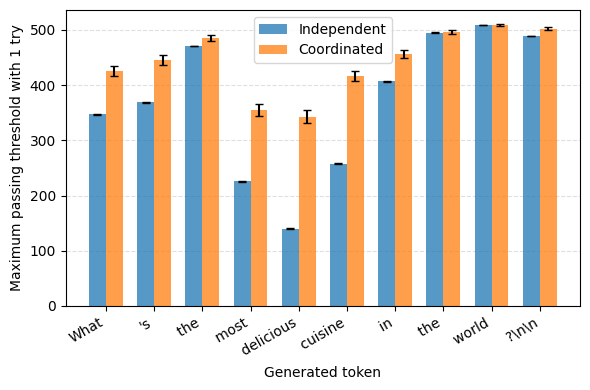

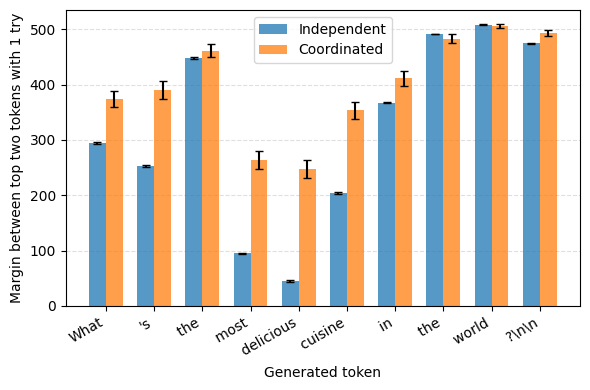

In [ ]:
stop_fn = create_stop_fn(tokenizer)
print("Independent Max T | Coordinated Max T | Prefix")

for i in range(10):
    for num_repetitions_for_max_votes in [1, 5, 10]:
        num_samples_for_max_votes = 100 // num_repetitions_for_max_votes
        random_generator = ch.Generator(device=model.device).manual_seed(42 + i)
        prompt_dict = initialize_prompt_dict(teacher_prompts, tokenizer)
        prev_generation = ""
        generated_tokens = []

        ind_max_votes = []
        ind_max_votes_std = []
        coo_max_votes = []
        coo_max_votes_std = []

        ind_max_margins = []
        ind_max_margins_std = []
        coo_max_margins = []
        coo_max_margins_std = []

        while not stop_fn(generated_tokens):
            logits = compute_logits(prompt_dict, model, tokenizer)
            probs = logits_to_probs(logits).mean(dim=0)
            token = ch.multinomial(
                probs, num_samples=1, generator=random_generator
            ).item()

            (
                cur_ind_max_votes,
                cur_ind_max_votes_std,
                cur_ind_max_margins,
                cur_ind_max_margins_std,
            ) = get_max_votes_and_margins(
                logits,
                ind_sampler,
                num_samples_for_max_votes,
                num_repetitions_for_max_votes,
            )
            (
                cur_coo_max_votes,
                cur_coo_max_votes_std,
                cur_coo_max_margins,
                cur_coo_max_margins_std,
            ) = get_max_votes_and_margins(
                logits,
                coo_sampler,
                num_samples_for_max_votes,
                num_repetitions_for_max_votes,
            )

            generated_tokens.append(token)
            update_prompt_dict(prompt_dict, token)
            cur_generation = tokenizer.decode(generated_tokens)
            print(
                f"{cur_ind_max_votes:.1f} ({cur_ind_max_votes_std:.1f})",
                "|",
                f"{cur_coo_max_votes:.1f} ({cur_coo_max_votes_std:.1f})",
                "|",
                prev_generation,
            )
            ind_max_votes.append(cur_ind_max_votes)
            ind_max_votes_std.append(cur_ind_max_votes_std)
            coo_max_votes.append(cur_coo_max_votes)
            coo_max_votes_std.append(cur_coo_max_votes_std)

            ind_max_margins.append(cur_ind_max_margins)
            ind_max_margins_std.append(cur_ind_max_margins_std)
            coo_max_margins.append(cur_coo_max_margins)
            coo_max_margins_std.append(cur_coo_max_margins_std)

            prev_generation = cur_generation
        print(cur_generation)
        save_path = (
            Path("outputs")
            / f"max_passing_threshold_{num_repetitions_for_max_votes}_retries"
            / f"sample_{i}.pdf"
        )
        plot_max_metrics(
            "Maximum passing threshold",
            ind_max_votes,
            ind_max_votes_std,
            coo_max_votes,
            coo_max_votes_std,
            generated_tokens,
            tokenizer,
            save_path=save_path,
            num_repetitions_for_max_votes=num_repetitions_for_max_votes,
        )
        save_path = (
            Path("outputs")
            / f"max_margin_{num_repetitions_for_max_votes}_retries"
            / f"sample_{i}.pdf"
        )
        plot_max_metrics(
            "Margin between top two tokens",
            ind_max_margins,
            ind_max_margins_std,
            coo_max_margins,
            coo_max_margins_std,
            generated_tokens,
            tokenizer,
            save_path=save_path,
            num_repetitions_for_max_votes=num_repetitions_for_max_votes,
        )